# Fitting a Linear Model
This notebook demonstrates how to build the most basic model with `calibr8`.

We begin with importing the relevant packages:

In [1]:
from matplotlib import pyplot, cm
import numpy

import calibr8

## Inspecting the calibration data points
At the beginning of almost every data analysis it is always a good idea to take a brief look at the data.

For the purpose of this notebook, the dataset is randomly generated.

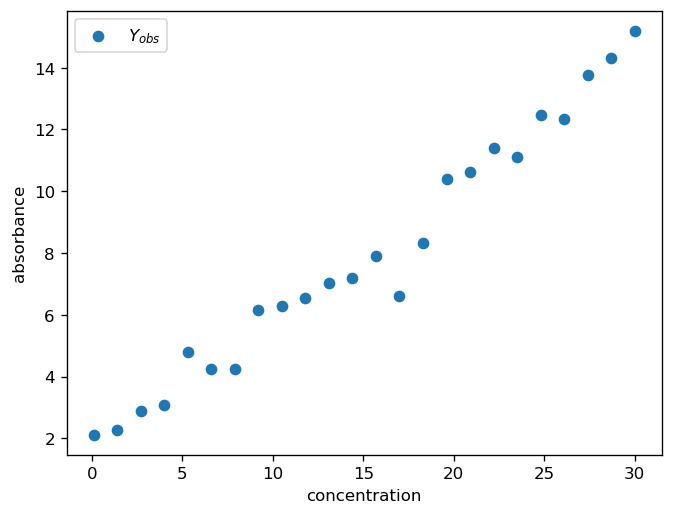

In [2]:
# generate 24 calibration points with t-distributed noise
numpy.random.seed(666)
N = 24
X = numpy.linspace(0.1, 30, N)
Y = 1.7 + 0.43 * X + 0.5 * numpy.random.standard_t(df=3, size=N)

fig, ax = pyplot.subplots(dpi=120)
ax.scatter(X, Y, label='$Y_{obs}$')
ax.set_xlabel('concentration')
ax.set_ylabel('absorbance')
ax.legend()
pyplot.show()

## Setting up the model
A _linear_ function is the 2nd-simplest version of a polynomial. (The simplest being a 0th-order polynomial–a constant–but that's not very helpful here.)

To create a linear model, we can use the `calibr8.BasePolynomialModelT` and specify a `mu_degree=1`.

The `Base...ModelT` uses a [Student-t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), which is robust against outliers and has some numerical advantages for modeling.

In [3]:
class ToyLinearModelV1(calibr8.BasePolynomialModelT):
    def __init__(self):
        super().__init__(
            independent_key='concentration',
            dependent_key='absorbance',
            mu_degree=1,
            scale_degree=0,
        )
        
model = ToyLinearModelV1()

## Fitting the model to data
A `calibr8.CalibrationModel` is typically fitted by _optimization_ using one of the helper functions from the `calibr8.optimization` module.

The `fit_scipy` helper function works for about 90 % of the cases. If you have trouble finding a good fit for your model, you can try to make a better initial guess of the parameters and specify tighter bounds. For more tips on model fitting, see the "In-depth Model Fitting" example.

In [4]:
# the helper function returns:
# + the optimized model parameter vector `theta_fit`
# + the history of parameter vectors tested in the optimization
# It also assignes some relevant variables to the `model`.
theta_fit, history = calibr8.fit_scipy(
    model=model,
    independent=X, dependent=Y,
    theta_guess=[1, 0.5, 1, 1],
    theta_bounds=[
        (-2, 5),
        (0, 2),
        (0.01, 5),
        (1, 50),
    ]
)

After the `fit_scipy` function ran without warnings, we can use the `calibr8.plot_model` function to inspect the model fit.

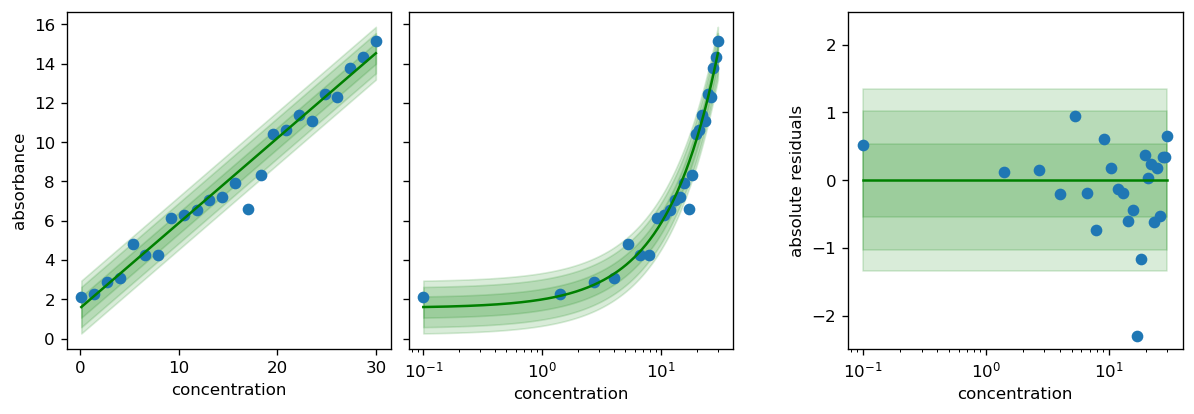

In [5]:
# the function returns the matplotlib Figure and Axes, so you can do more with it.
fig, axs = calibr8.plot_model(model)
pyplot.show()

Alternatively, you can use the `fit_scipy_global` helper function which does not require an initial guess and can handle wider bounds, but entails a longer computation time.  
The procedure does not differ much when using global optmization.

In [6]:
theta_fit, history = calibr8.fit_scipy_global(
    model=model,
    independent=X, dependent=Y,
    theta_bounds=[
        (-20, 20),
        (0, 20),
        (0, 20),
        (1, 100),
    ]
)



C:\Users\siska\Miniconda3\envs\calibr8-wip-2\lib\site-packages\scipy\stats\_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


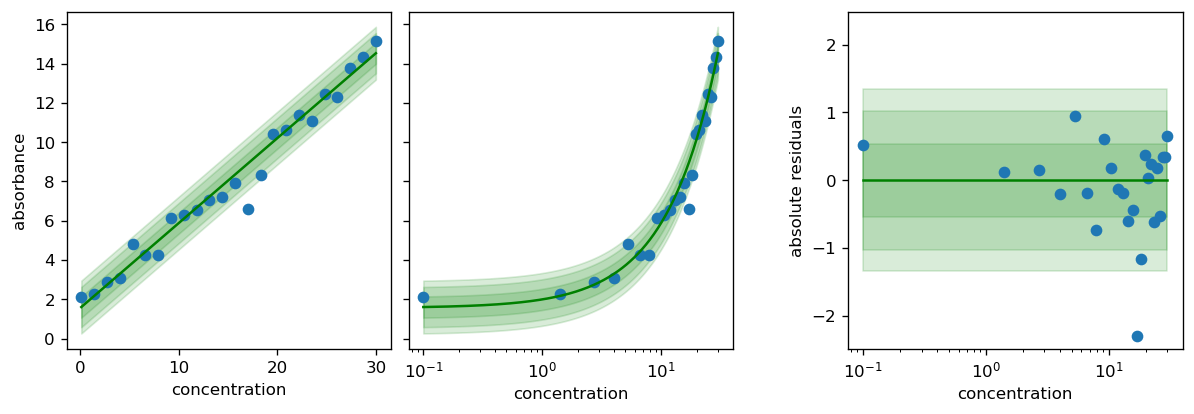

In [7]:
# the function returns the matplotlib Figure and Axes, so you can do more with it.
fig, axs = calibr8.plot_model(model)
pyplot.show()

## Using the fitted model
One common use case for such a calibration model is the inference of a dependent variable (concentration) from observations (absorbances).

All `calibr8.CalibrationModel`s have a `.infer_independent()` method that numerically does this for you.

In [8]:
result = model.infer_independent(
    # we must pass one or more observations, and a lower/upper bound of plausible concentration
    y=[5.9, 6.0],
    lower=0, upper=30,
    ci_prob=0.9,
)
print(result)

<class 'calibr8.core.ContinuousUnivariateInference'>
    ETI (90.0 %): [8.8097, 11.4909] Δ=2.6812
    HDI (90.0 %): [8.8097, 11.4909] Δ=2.6812


The returned object is a `calibr8.NumericPosterior` with useful properties such as the `median`, or the `lower_hdi` and `upper_hdi`.

In [9]:
print(f"The median of the posterior is {result.median:.1f}")
print(
    f"With {result.hdi_prob*100:.0f} % probabilty, "
    f"the concentration is between {result.hdi_lower:.1f} and {result.hdi_upper:.1f}."
)

The median of the posterior is 10.2
With 90 % probabilty, the concentration is between 8.8 and 11.5.


We can plot the posterior density from the `.eti_x` and `.eti_pdf` properties:

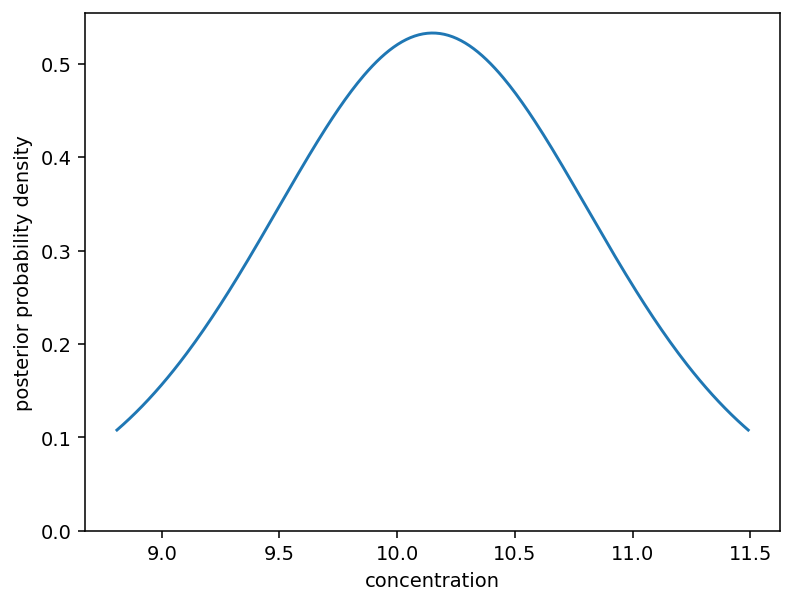

In [10]:
fig, ax = pyplot.subplots(dpi=140)
ax.plot(
    result.eti_x,
    result.eti_pdf,
)
ax.set_ylim(0)
ax.set_ylabel("posterior probability density")
ax.set_xlabel("concentration")
pyplot.show()

For more details on the `.infer_independent()` method, see the "Numeric Independent Posterior" example.

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Sep 01 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

numpy     : 1.23.2
calibr8   : 6.5.3
matplotlib: 3.5.3

Watermark: 2.3.1

